In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.decomposition import PCA
from sklearn.preprocessing import minmax_scale
from torch.utils.data import DataLoader
from torchvision import transforms as T
from transformers import AutoImageProcessor, AutoModel

from oadino.clevr import load_clevr_dataset
from oadino.models import ConvVAE16, OADinoModel, OADinoPreProcessor

In [2]:
img_size = 224
dinov2_vits14 = torch.hub.load("facebookresearch/dinov2", "dinov2_vits14")
dinov2_vits14 = dinov2_vits14.cuda()
dinov2_vits14.eval()
patch_h = patch_w = img_size // 14

Using cache found in /home/rya/.cache/torch/hub/facebookresearch_dinov2_main
/home/rya/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/rya/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/rya/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


In [3]:
# Load clevr data for visualization

transform = T.Compose(
    [
        T.ToTensor(),
        T.Resize(img_size + int(img_size * 0.01) * 10),
        T.CenterCrop(img_size),
        T.Normalize([0.5], [0.5]),
    ]
)

_, _, val_dataset = load_clevr_dataset(
    Path("/ssd2/mldata/CLEVR_v1.0/images"), maxsize=4096, transform=transform
)
val_loader = DataLoader(val_dataset, batch_size=8)
batch_size=8

In [4]:
batch = next(iter(val_loader))
images = batch["image"]  # torch.Size([8, 3, 224, 224])

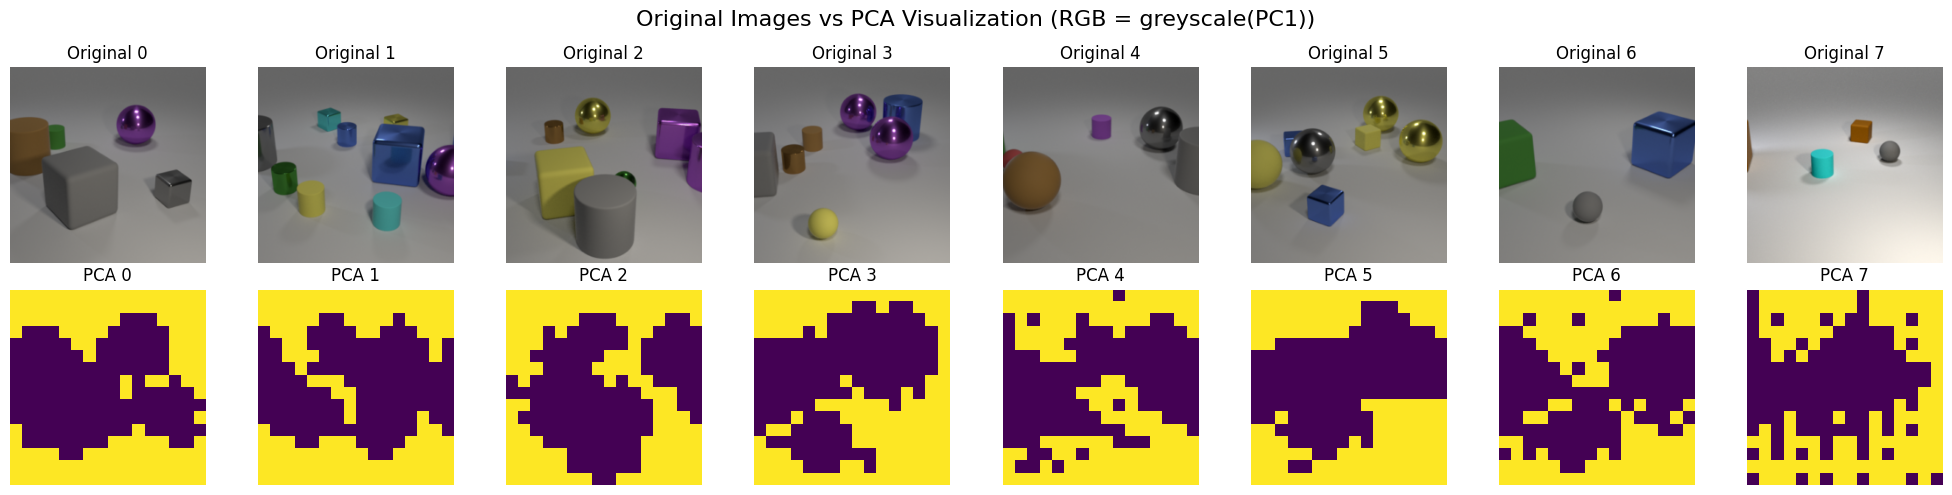

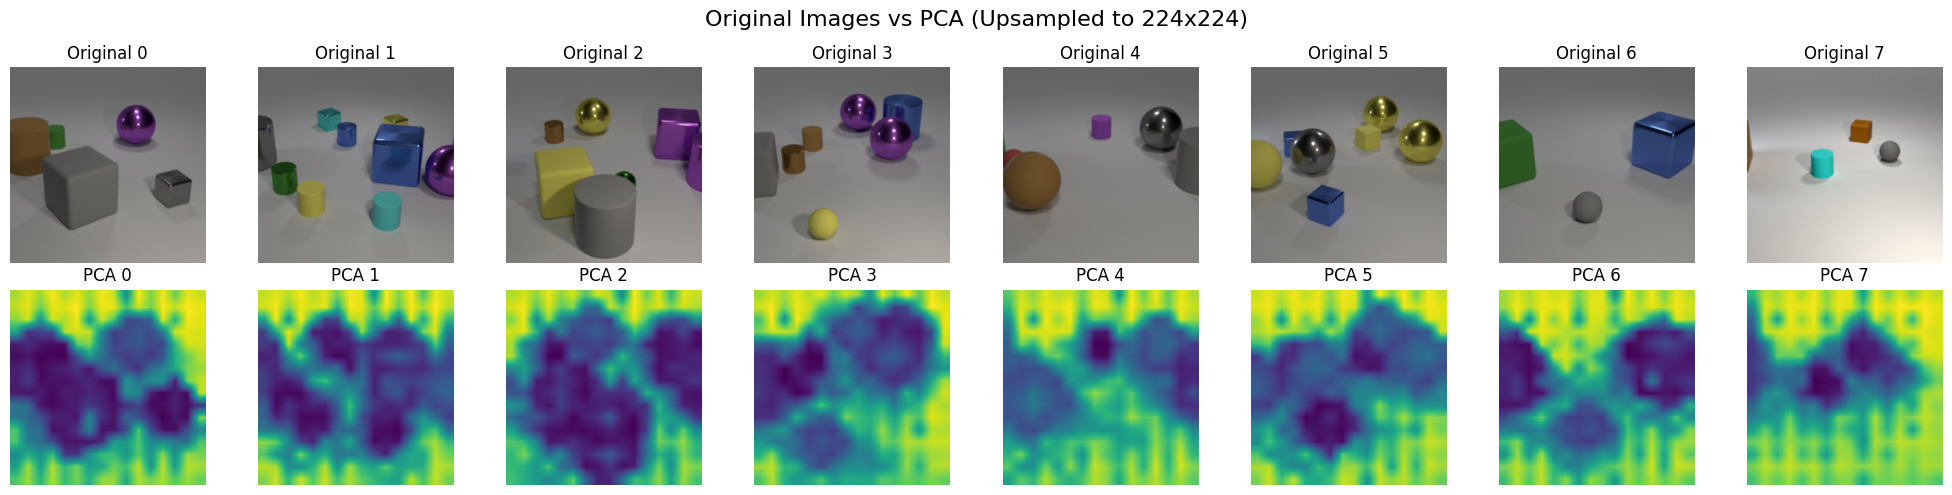

(16, 16)

In [6]:
# Process images through DINOv2
with torch.no_grad():
    # embeddings = dinov2_vitb14.forward_features(images.cuda())
    embeddings = dinov2_vits14.forward_features(images.cuda())
    x_norm_patchtokens = embeddings["x_norm_patchtokens"].cpu().numpy()

    x_norm_1616_patches = x_norm_patchtokens.reshape(batch_size * patch_h * patch_w, -1)

    fg_pca = PCA(n_components=1)
    fg_pca_images = fg_pca.fit_transform(x_norm_1616_patches)
    fg_pca_images = minmax_scale(fg_pca_images)
    fg_pca_images = fg_pca_images.reshape(batch_size, patch_h, patch_w)


# Visualize results
fig, axes = plt.subplots(2, 8, figsize=(20, 5))
# fig.suptitle('Original Images vs PCA Visualization (RGB = PC1, PC2, PC3)', fontsize=16)
fig.suptitle("Original Images vs PCA Visualization (RGB = greyscale(PC1))", fontsize=16)

for i in range(8):
    # Original image
    img = images[i].cpu().permute(1, 2, 0).numpy()
    img = (img - img.min()) / (img.max() - img.min() + 1e-8)
    axes[0, i].imshow(img)
    axes[0, i].axis("off")
    axes[0, i].set_title(f"Original {i}")

    # PCA visualization (16x16 will be upsampled by imshow)
    pca_img = fg_pca_images[i]
    pca_img = pca_img > np.median(pca_img)
    pca_img = pca_img.astype(np.float32)
    axes[1, i].imshow(pca_img, interpolation="nearest")
    axes[1, i].axis("off")
    axes[1, i].set_title(f"PCA {i}")

plt.tight_layout()
plt.show()

# Optional: Show higher resolution PCA by upsampling to match original image size
fig, axes = plt.subplots(2, 8, figsize=(20, 5))
fig.suptitle("Original Images vs PCA (Upsampled to 224x224)", fontsize=16)

for i in range(8):
    # Original image
    img = images[i].cpu().permute(1, 2, 0).numpy()
    img = (img - img.min()) / (img.max() - img.min() + 1e-8)
    axes[0, i].imshow(img)
    axes[0, i].axis("off")
    axes[0, i].set_title(f"Original {i}")

    # PCA visualization upsampled
    pca_img = fg_pca_images[i]
    axes[1, i].imshow(pca_img, interpolation="bilinear")  # Smooth upsampling
    axes[1, i].axis("off")
    axes[1, i].set_title(f"PCA {i}")

plt.tight_layout()
plt.show()
fg_pca_images[i].shape

In [7]:
fg_pca_images

array([[[0.86820865, 0.9504323 , 0.85832286, ..., 0.7706435 ,
         0.96693134, 0.9096635 ],
        [0.9021529 , 0.9658083 , 0.7863619 , ..., 0.9096385 ,
         0.9948933 , 0.9608557 ],
        [0.8210596 , 0.9323001 , 0.5311371 , ..., 0.63239586,
         0.9834063 , 0.952756  ],
        ...,
        [0.481791  , 0.6186962 , 0.5122943 , ..., 0.49507657,
         0.8446013 , 0.78809863],
        [0.56121165, 0.8733586 , 0.5632225 , ..., 0.5616753 ,
         0.8932206 , 0.8650247 ],
        [0.72468334, 0.8544282 , 0.65304506, ..., 0.7420869 ,
         0.84644747, 0.7757727 ]],

       [[0.88775814, 0.9374923 , 0.87994176, ..., 0.70705765,
         0.9613815 , 0.8925996 ],
        [0.9153385 , 0.97163606, 0.7973671 , ..., 0.8605585 ,
         0.98453957, 0.8681576 ],
        [0.5518532 , 0.9726441 , 0.49448946, ..., 0.5809481 ,
         0.9515103 , 0.6441102 ],
        ...,
        [0.71386325, 0.50388306, 0.4071669 , ..., 0.5706848 ,
         0.87108463, 0.7620023 ],
        [0.8

In [8]:
# Load a pretrained VAE checkpoint

checkpoint_path = Path(
    "runs/CLEVR_train_4K_224_20260202_210355/checkpoints/best_model.pt"
)
checkpoint = torch.load(checkpoint_path)
state_dict = checkpoint["model_state_dict"]

model = OADinoModel(ConvVAE16())
# model = OADinoModel(ConvVAE64)

model.load_state_dict(state_dict)

<All keys matched successfully>

In [10]:
# pre_processor = OADinoPreProcessor(dinov2_vitb14)
pre_processor = OADinoPreProcessor(dinov2_vits14)

# Visualizing PCA applied to images passed through DINO

In [11]:
it = iter(val_loader)

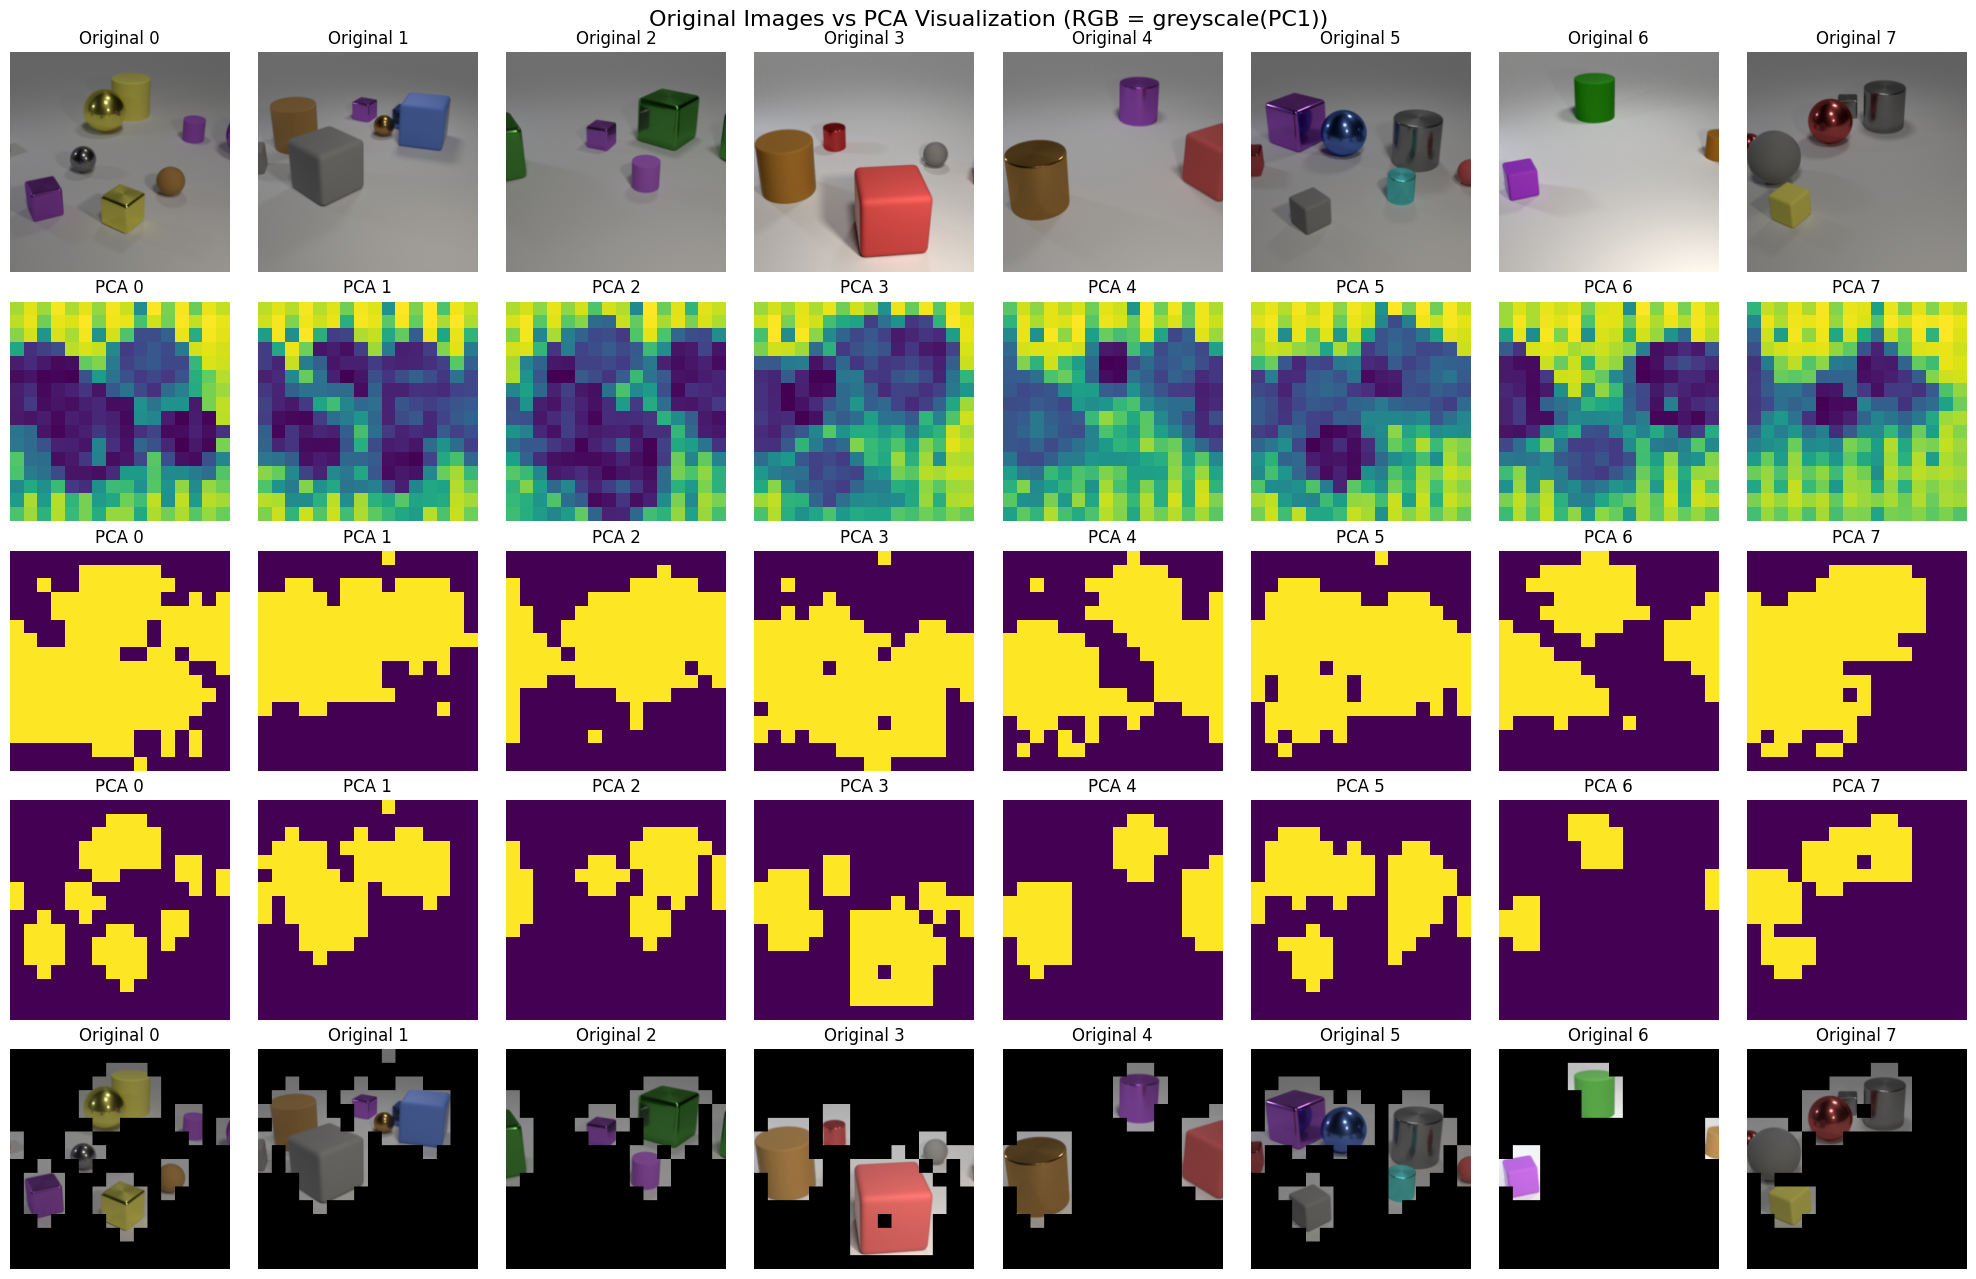

In [13]:
batch = next(it)
images = batch["image"]  # torch.Size([8, 3, 224, 224])

segmented_images, mask, backbone_patches, rough_mask = pre_processor.segment_images(images.cuda(), add_opt_outputs=True)

mask = mask.reshape((8, 1, 16, 16))
rough_mask = rough_mask.reshape((8, 1, 16, 16))
# backbone_patches = backbone_patches.reshape((8, 16, 16, 768))
backbone_patches = backbone_patches.reshape((8, 16, 16, 384))
backbone_patches = backbone_patches.reshape(batch_size * patch_h * patch_w, -1)
fg_pca = PCA(n_components=1)
fg_pca_images = fg_pca.fit_transform(x_norm_1616_patches)
fg_pca_images = minmax_scale(fg_pca_images)
fg_pca_images = fg_pca_images.reshape(batch_size, patch_h, patch_w, 1)

# Visualize results
fig, axes = plt.subplots(5, 8, figsize=(20, 13))
# fig.suptitle('Original Images vs PCA Visualization (RGB = PC1, PC2, PC3)', fontsize=16)
fig.suptitle("Original Images vs PCA Visualization (RGB = greyscale(PC1))", fontsize=16)

for i in range(8):
    # Original image
    img = images[i].cpu().permute(1, 2, 0).numpy()
    img = (img - img.min()) / (img.max() - img.min() + 1e-8)
    axes[0, i].imshow(img)
    axes[0, i].axis("off")
    axes[0, i].set_title(f"Original {i}")

    # PCA visualization (16x16 will be upsampled by imshow)
    pca_img = fg_pca_images[i]
    axes[1, i].imshow(pca_img, interpolation="nearest")
    axes[1, i].axis("off")
    axes[1, i].set_title(f"PCA {i}")

    # rough mask visualization (16x16 will be upsampled by imshow)
    rough_mask_img = rough_mask[i].float().cpu().permute(1, 2, 0).numpy()
    axes[2, i].imshow(rough_mask_img, interpolation="nearest")
    axes[2, i].axis("off")
    axes[2, i].set_title(f"PCA {i}")

    # mask visualization (16x16 will be upsampled by imshow)
    mask_img = mask[i].float().cpu().permute(1, 2, 0).numpy()
    axes[3, i].imshow(mask_img, interpolation="nearest")
    axes[3, i].axis("off")
    axes[3, i].set_title(f"PCA {i}")

    # final segmented image visualization
    segmented_img = segmented_images[i].cpu().permute(1, 2, 0).numpy()
    segmented_img = (segmented_img - segmented_img.min()) / (segmented_img.max() - segmented_img.min() + 1e-8)
    axes[4, i].imshow(segmented_img)
    axes[4, i].axis("off")
    axes[4, i].set_title(f"Original {i}")

plt.tight_layout()
plt.show()

In [14]:
global_features, object_patches, mask = pre_processor.get_global_features_and_patches(
    images.cuda()
)

print(f"{global_features.shape=}")  # global_features.shape=torch.Size([8, 768])
print(
    f"{object_patches.shape=}"
)  # object_patches.shape=torch.Size([8, 256, 3, 14, 14])
print(f"{mask.shape=}")  # mask.shape=torch.Size([8, 256])

# TODO
# Show the first image in the path in a plot
# Show the resulting object patches that aren't masked by the given binary mask for the first image in the batch
# Not all but some of them [around 8 ?]

global_features.shape=torch.Size([8, 384])
object_patches.shape=torch.Size([8, 256, 3, 14, 14])
mask.shape=torch.Size([8, 256])


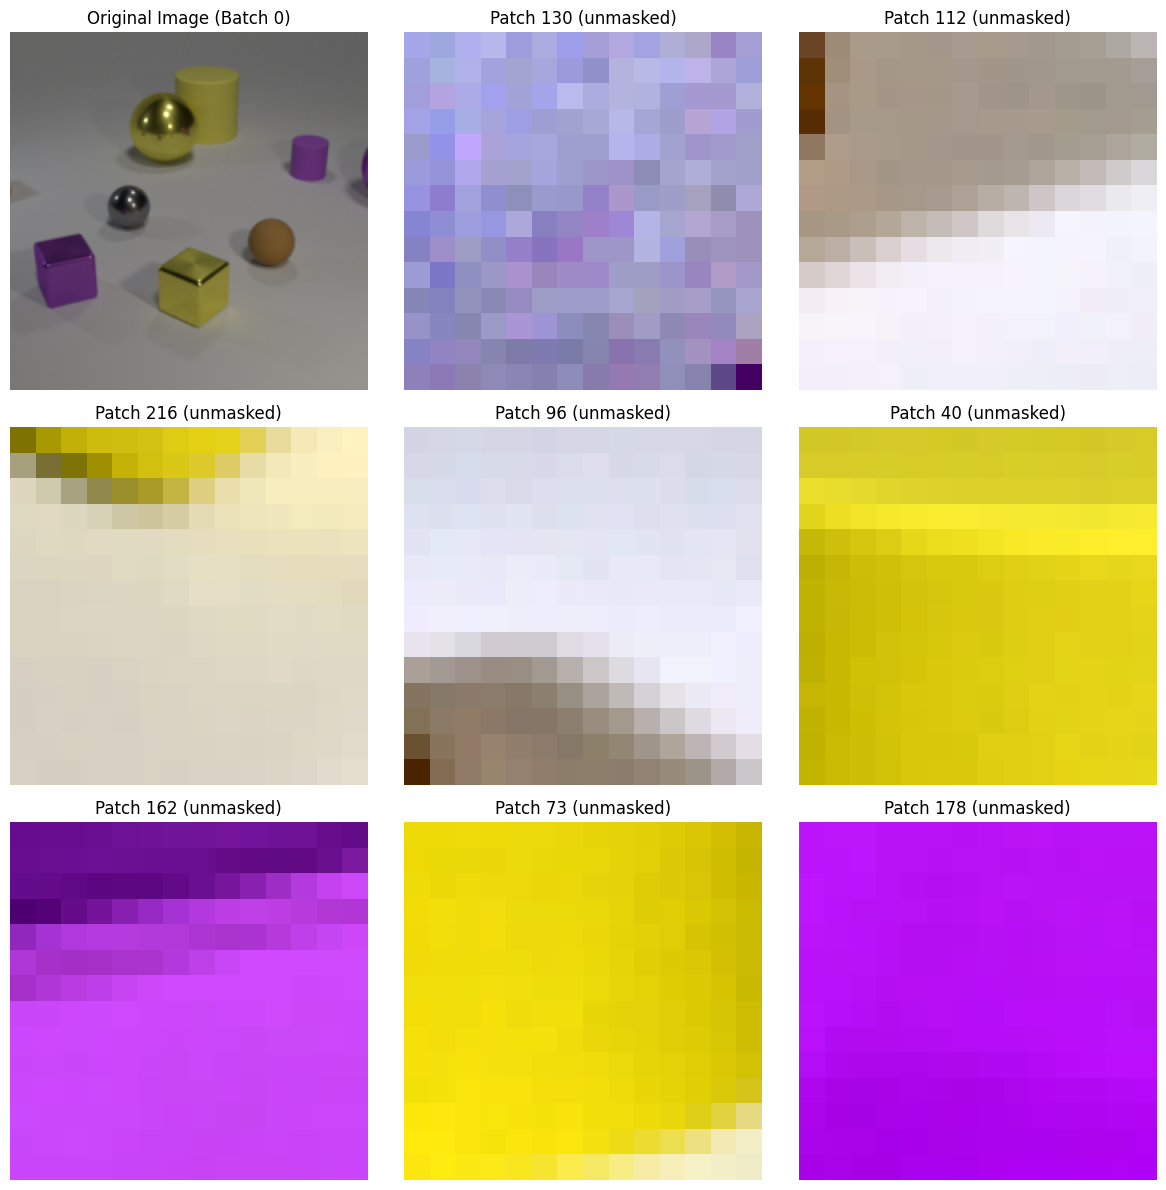

Total unmasked patches: 67
Showing 8 random unmasked patches


In [15]:
import random

# Get the first image from the batch as an example
batch_idx = 0

# Get unmasked patch indices (where mask is True/1)
unmasked_indices = torch.where(mask[batch_idx] == 1)[0]

# Select around 8 random unmasked patches (or fewer if not enough available)
num_patches_to_show = min(8, len(unmasked_indices))
selected_patch_indices = random.sample(unmasked_indices.tolist(), num_patches_to_show)

# Create visualization
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
axes = axes.flatten()

# Show the original source image
original_image = images[batch_idx].permute(1, 2, 0).cpu()  # CHW -> HWC
# Denormalize if needed (assuming ImageNet normalization)
# mean = torch.tensor([0.485, 0.456, 0.406])
# std = torch.tensor([0.229, 0.224, 0.225])
# original_image = original_image * std + mean
original_image = (original_image - original_image.min()) / (original_image.max() - original_image.min() + 1e-8)

axes[0].imshow(original_image)
axes[0].set_title(f"Original Image (Batch {batch_idx})")
axes[0].axis('off')

# Show selected unmasked patches
for idx, patch_idx in enumerate(selected_patch_indices, start=1):
    patch = object_patches[batch_idx, patch_idx].permute(1, 2, 0).cpu()  # CHW -> HWC
    # Denormalize if needed
    # patch = patch * std + mean
    patch = (patch - patch.min()) / (patch.max() - patch.min() + 1e-8)
    
    axes[idx].imshow(patch)
    axes[idx].set_title(f"Patch {patch_idx} (unmasked)")
    axes[idx].axis('off')

# Hide any unused subplots
for idx in range(num_patches_to_show + 1, 9):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

print(f"Total unmasked patches: {len(unmasked_indices)}")
print(f"Showing {num_patches_to_show} random unmasked patches")

In [17]:
# dinov2_vitb14.norm.normalized_shape[0]
dinov2_vits14.norm.normalized_shape[0]

384